# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal ../../../data/data .

copyFromLocal: `data/.DS_Store': File exists
copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-09 17:57 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-09 17:58 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-09 17:58 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-09 17:58 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-09 17:58 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-09 17:58 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-09 17:58 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-09 17:58 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-09 17:58 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 2.01 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 20.7 ms, sys: 3.31 ms, total: 24 ms
Wall time: 1min 3s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id) \
    .distinct() \
    .count()

CPU times: user 23.3 ms, sys: 4.84 ms, total: 28.2 ms
Wall time: 1min 48s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id) \
    .distinct() \
    .count()

CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 31.9 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)'])),
 (198527, (5.0, ['198527', 'Drift (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating \
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
!hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-09 22:37 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58939 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112520 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131414 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114296 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133554 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117791 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143157 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132154 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167707 2021-02-09 22:37 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

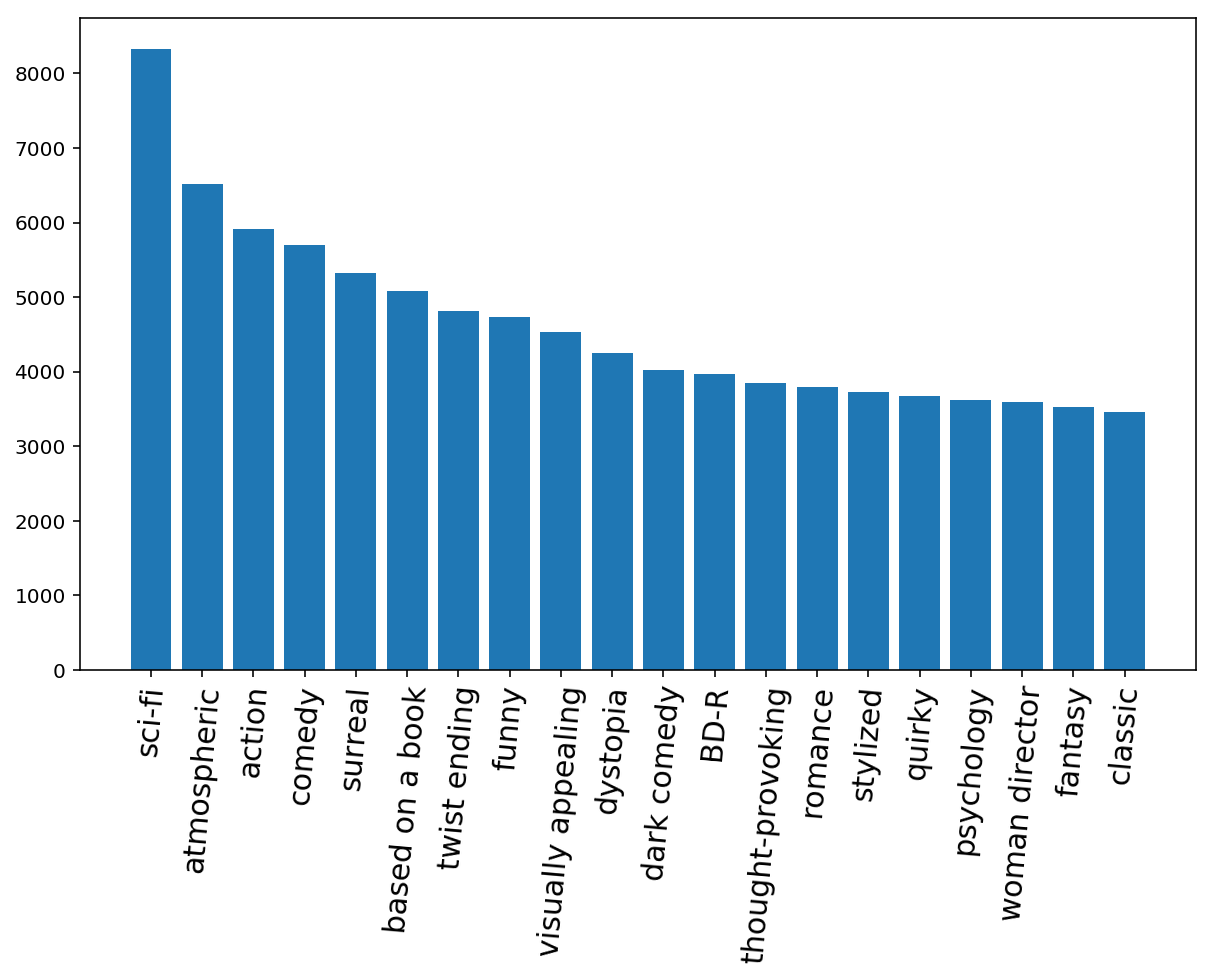

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_values: key_values[1], ascending=False) \
    .map(lambda key_values: (key_values[1][1][1], key_values[1][0])) \
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
ratings \
    .map(lambda r: (r.movie_id,  r.rating)) \
    .filter(lambda key_value: key_value[1] == 5) \
    .mapValues(lambda value: 1) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_values: key_values[1], ascending=False) \
    .map(lambda key_values: (key_values[1][1][1], key_values[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [26]:
avg_ratings = movie_avg_rating \
    .map(lambda key_value: key_value[1]) \
    .collect()

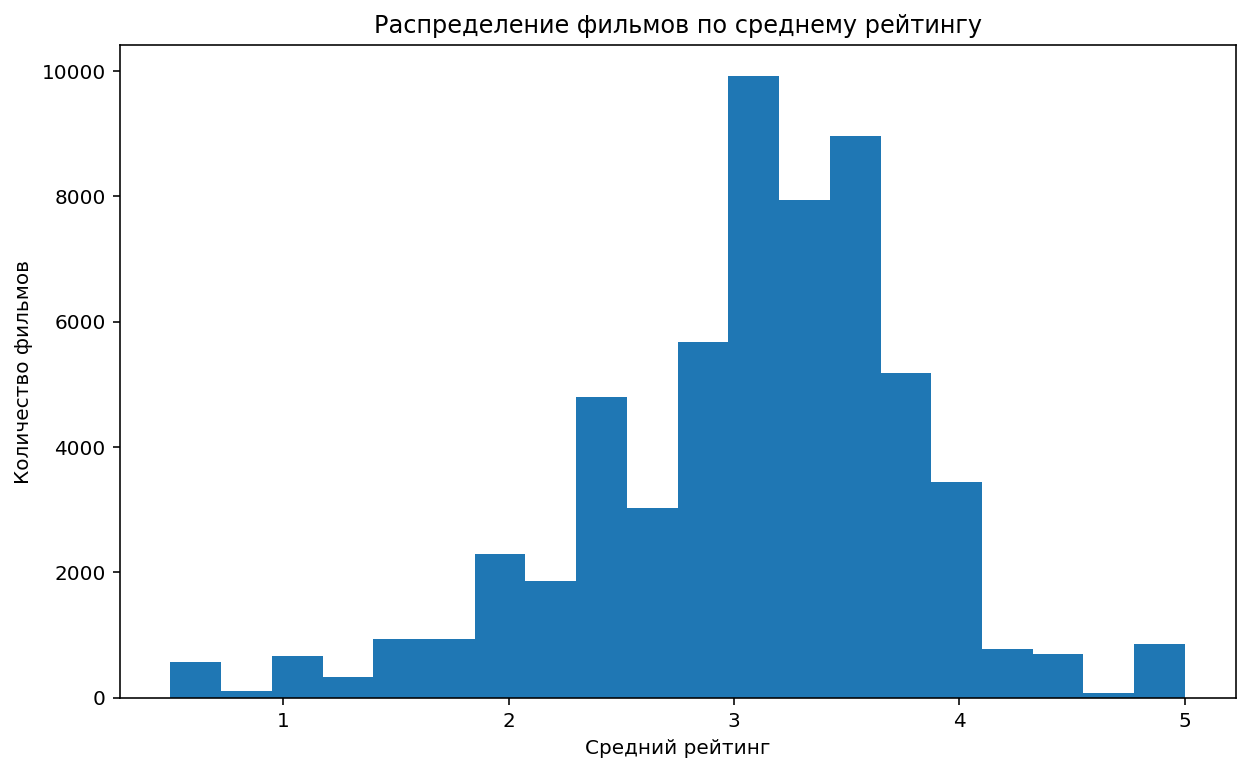

In [27]:
plt.figure(figsize=(10, 6))
plt.title('Распределение фильмов по среднему рейтингу')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество фильмов')
plt.hist(avg_ratings, bins=20);

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [28]:
ratings_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda key_value: key_value[1]) \
    .collect()

In [29]:
min(ratings_count), max(ratings_count)

(1, 81491)

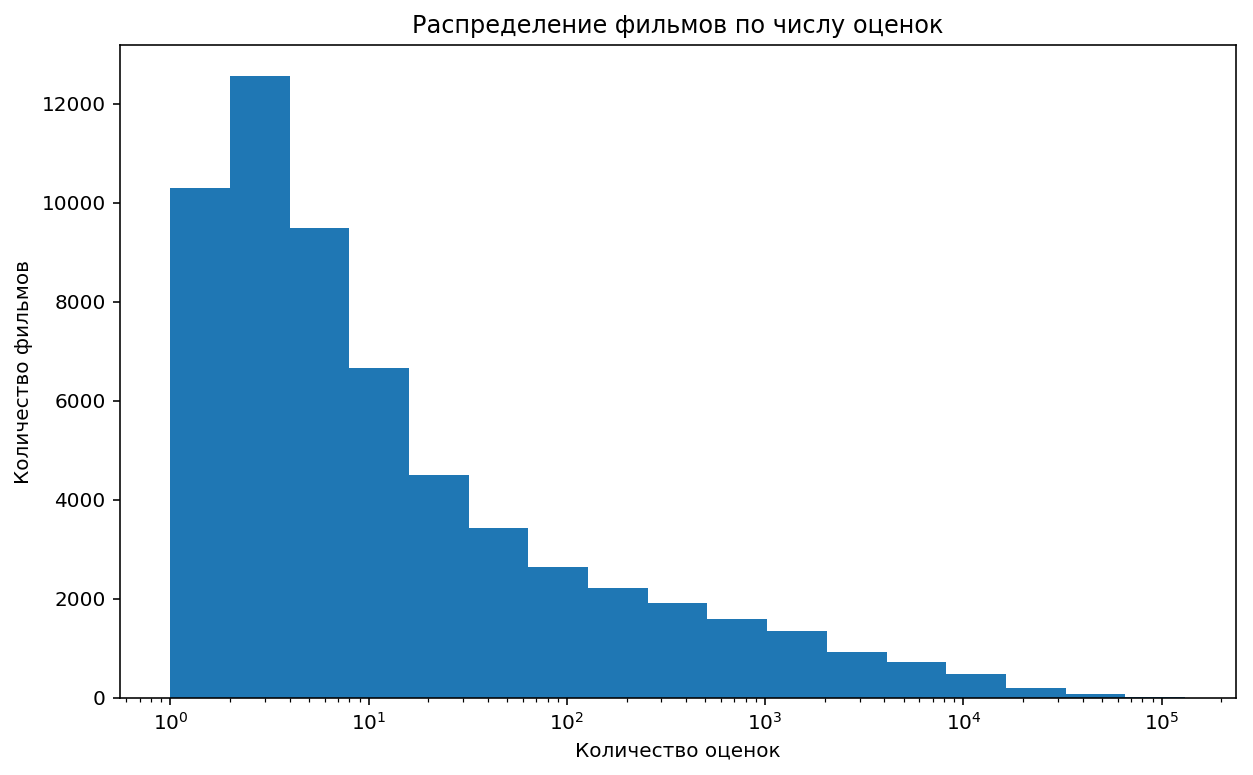

In [30]:
bins = [2 ** i for i in range(0, 18)]
plt.figure(figsize=(10, 6))
plt.title('Распределение фильмов по числу оценок')
plt.xlabel('Количество оценок')
plt.ylabel('Количество фильмов')
plt.xscale('log')
plt.hist(ratings_count, bins=bins);

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [31]:
movies_ = sc.textFile(MOVIES_PATH)

In [52]:
genres = movies_ \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .flatMap(lambda movie: [(genre, 1) for genre in movie[-1].split('|')]) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda row: row[1], ascending=False) \
    .collect()

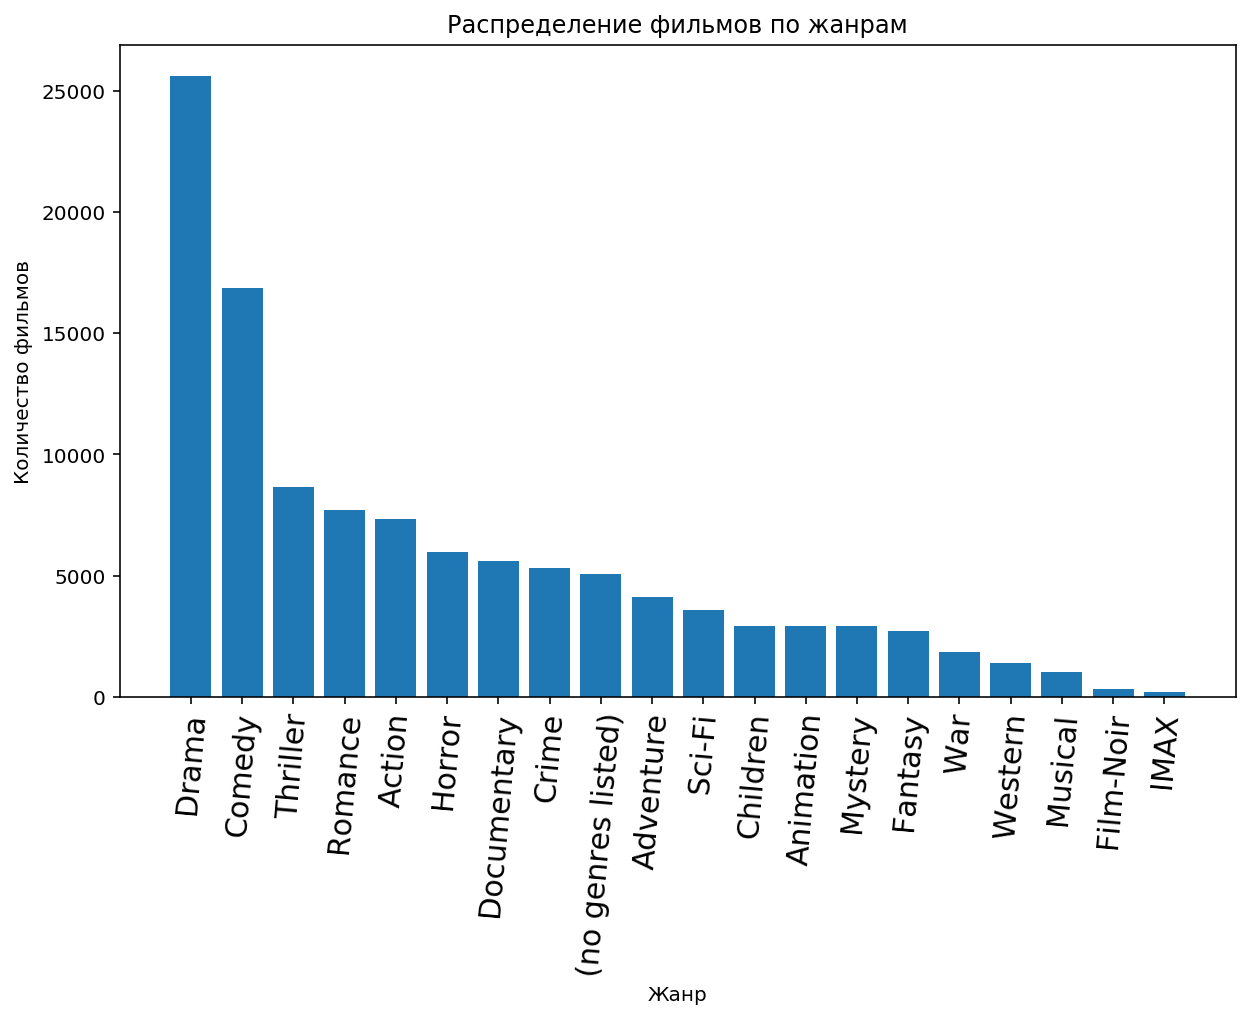

In [53]:
keys, values = zip(*genres)

f, ax = plt.subplots(figsize=(10, 6))
plt.title('Распределение фильмов по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [34]:
import json

In [35]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [36]:
links = sc.textFile(LINKS_PATH)
tmdb = sc.textFile(TMDB_PATH).map(json.loads)

In [37]:
tmdb \
    .filter(lambda movie: 'title' in movie) \
    .map(lambda movie: (movie['title'], movie['casts']['cast'])) \
    .filter(lambda movie: 31 in [cast['id'] for cast in movie[1]]) \
    .map(lambda movie: movie[0]) \
    .collect()

['Toy Story',
 'Apollo 13',
 'Forrest Gump',
 'Philadelphia',
 'Sleepless in Seattle',
 'The Celluloid Closet',
 'That Thing You Do!',
 'Saving Private Ryan',
 "The 'Burbs",
 'Splash',
 'The Money Pit',
 'Nothing in Common',
 "You've Got Mail",
 'Big',
 'Return with Honor',
 'Toy Story 2',
 'The Bonfire of the Vanities',
 'The Green Mile',
 'A League of Their Own',
 'Volunteers',
 'Bachelor Party',
 'Punchline',
 'Cast Away',
 'Turner & Hooch',
 "He Knows You're Alone",
 'Joe Versus the Volcano',
 'Road to Perdition',
 'Catch Me If You Can',
 'Radio Flyer',
 'Dragnet',
 'The Ladykillers',
 'The Terminal',
 'The Man with One Red Shoe',
 'The Polar Express',
 'The Da Vinci Code',
 'Cars',
 'The Simpsons Movie',
 "Charlie Wilson's War",
 'The Great Buck Howard',
 'Angels & Demons',
 'Shooting War',
 'Toy Story 3',
 'The Pixar Story',
 'Larry Crowne',
 'Extremely Loud & Incredibly Close',
 'Beyond All Boundaries',
 'Cloud Atlas',
 'Captain Phillips',
 'Toy Story of Terror!',
 'Saving Mr. B

In [38]:
tmdb \
    .filter(lambda movie: ('casts' in movie) and ('cast' in movie['casts'])) \
    .flatMap(lambda movie: [(cast['id'], (cast['name'], 1)) for cast in movie['casts']['cast']]) \
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1])) \
    .sortBy(lambda actor: actor[1][1], ascending=False) \
    .map(lambda actor: actor[1]) \
    .take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

### Доля жанра в течение времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [39]:
genres_info = tmdb \
    .filter(lambda movie: 'release_date' in movie) \
    .map(lambda movie: (movie['release_date'][:4], movie['genres'])) \
    .filter(lambda row: row[0].isdigit()) \
    .flatMap(lambda row: [((int(row[0]), genre['id']), (genre['name'], 1)) for genre in row[1]]) \
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1])) \
    .map(lambda row: (row[0][0], row[1][0], row[1][1])) \
    .collect()

In [40]:
genres_info[:10]

[(1969, 'TV Movie', 4),
 (1895, 'Comedy', 2),
 (1955, 'Music', 15),
 (1960, 'War', 24),
 (1917, 'Drama', 11),
 (1953, 'Adventure', 37),
 (1912, 'Western', 1),
 (1965, 'History', 15),
 (1912, 'Adventure', 1),
 (1957, 'History', 10)]

In [41]:
min_year = min([year for year, _, _ in genres_info])
max_year = max([year for year, _, _ in genres_info])
min_year, max_year

(1874, 2021)

In [42]:
years = range(min_year, max_year + 1)
genres_types = set([genre for _, genre, _ in genres_info])

In [43]:
print(', '.join(genres_types))

Crime, Comedy, TV Movie, Thriller, Adventure, Mystery, Fantasy, Action, Western, Drama, Horror, Romance, Documentary, Animation, History, Science Fiction, Music, War, Family


In [44]:
movies_per_year = [0 for _ in range(len(years))]
for year, genre, counts in genres_info:
    movies_per_year[year - min_year] += counts

In [45]:
genres_per_year = {genre: [0 for _ in range(len(years))] for genre in genres_types}
proportion_genres_per_year = {genre: [0 for _ in range(len(years))] for genre in genres_types}
for year, genre, counts in genres_info:
    genres_per_year[genre][year - min_year] = counts
    proportion_genres_per_year[genre][year - min_year] = counts / movies_per_year[year - min_year]

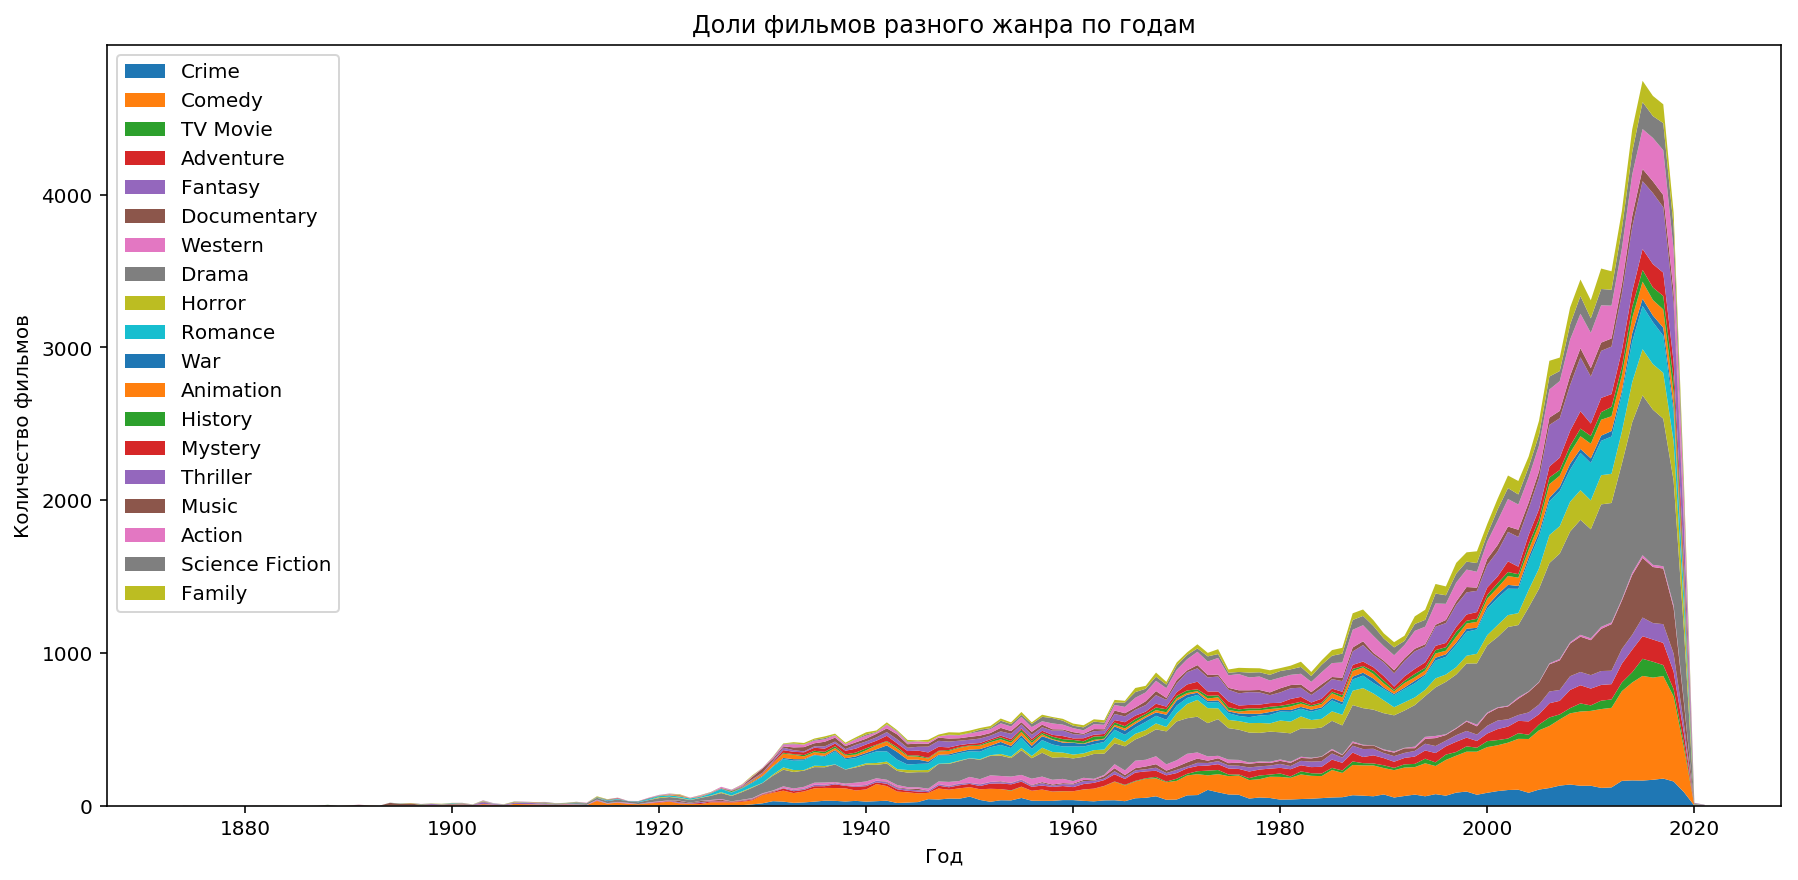

In [46]:
plt.figure(figsize=(15, 7))
plt.title('Доли фильмов разного жанра по годам')
plt.xlabel('Год')
plt.ylabel('Количество фильмов')
plt.stackplot(years, *genres_per_year.values(), labels=genres_per_year.keys())
plt.legend(loc='upper left')
plt.show()

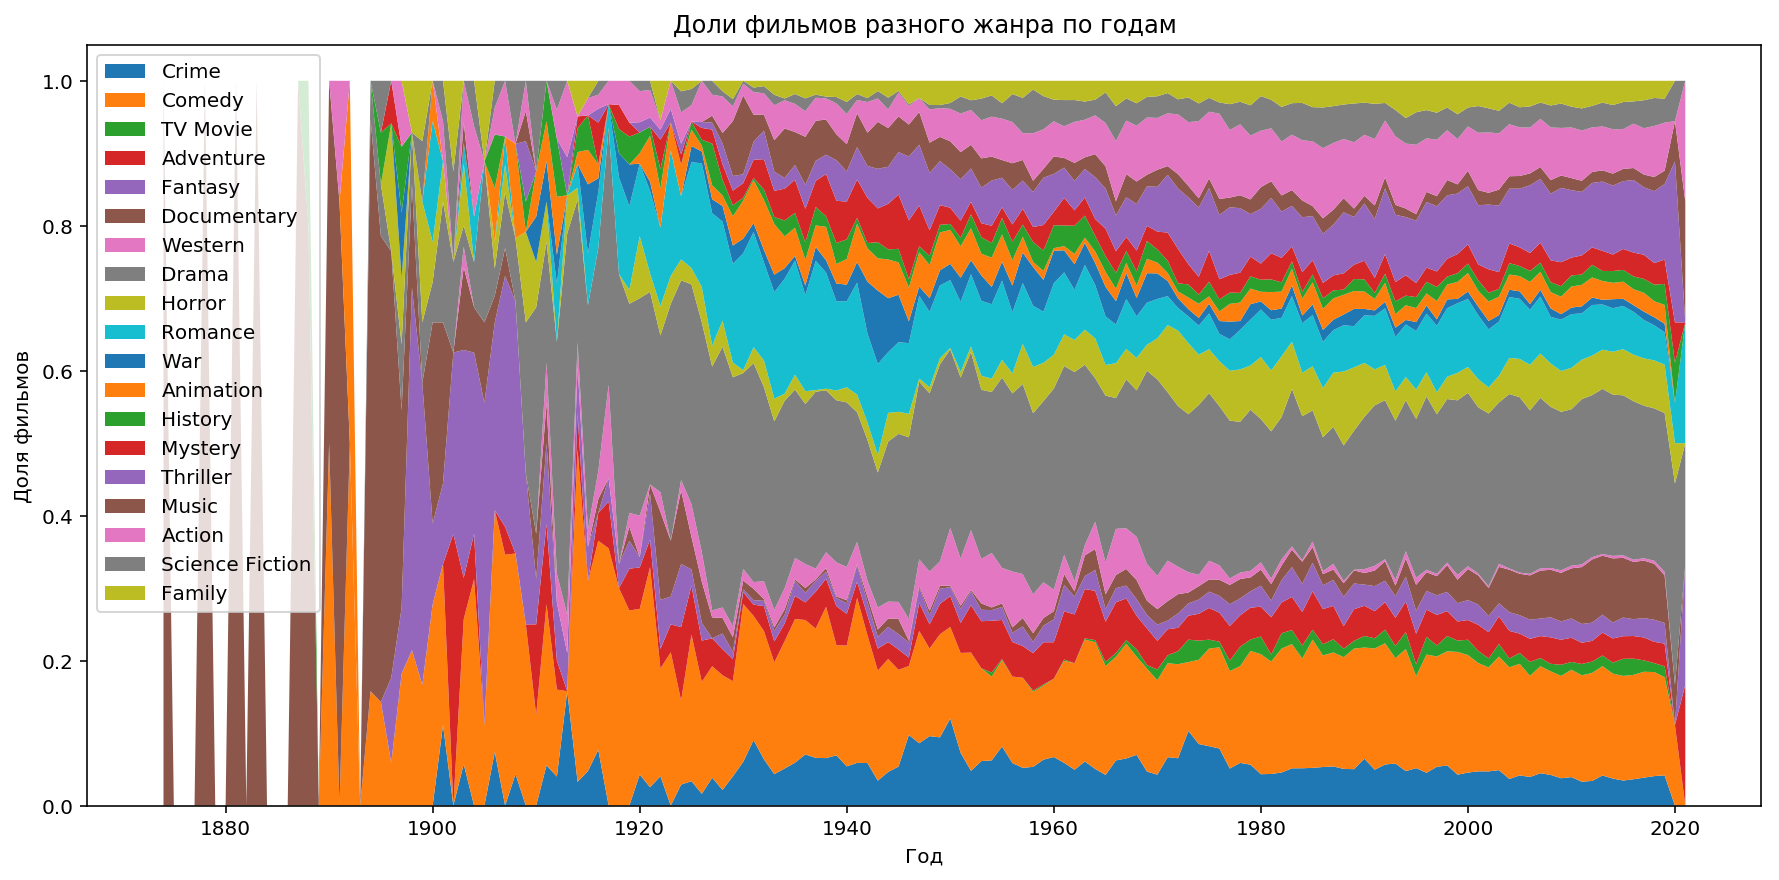

In [47]:
plt.figure(figsize=(15, 7))
plt.title('Доли фильмов разного жанра по годам')
plt.xlabel('Год')
plt.ylabel('Доля фильмов')
plt.stackplot(years, *proportion_genres_per_year.values(), labels=proportion_genres_per_year.keys())
plt.legend(loc='upper left')
plt.show()

Так как до 1920-х годов было мало фильмов, то график себя ведет немного неадекватно.

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [48]:
ROI = tmdb \
    .filter(lambda movie: ('genres' in movie) and ('revenue' in movie) and ('budget' in movie)) \
    .flatMap(lambda movie: [(genre['id'], (genre['name'], 
                             movie['revenue'], movie['budget'])) for genre in movie['genres']]) \
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1], a[2] + b[2])) \
    .map(lambda row: (row[1][0], row[1][1] / row[1][2])) \
    .sortBy(lambda row: row[1], ascending=False) \
    .collect()

In [49]:
keys, values = zip(*ROI)

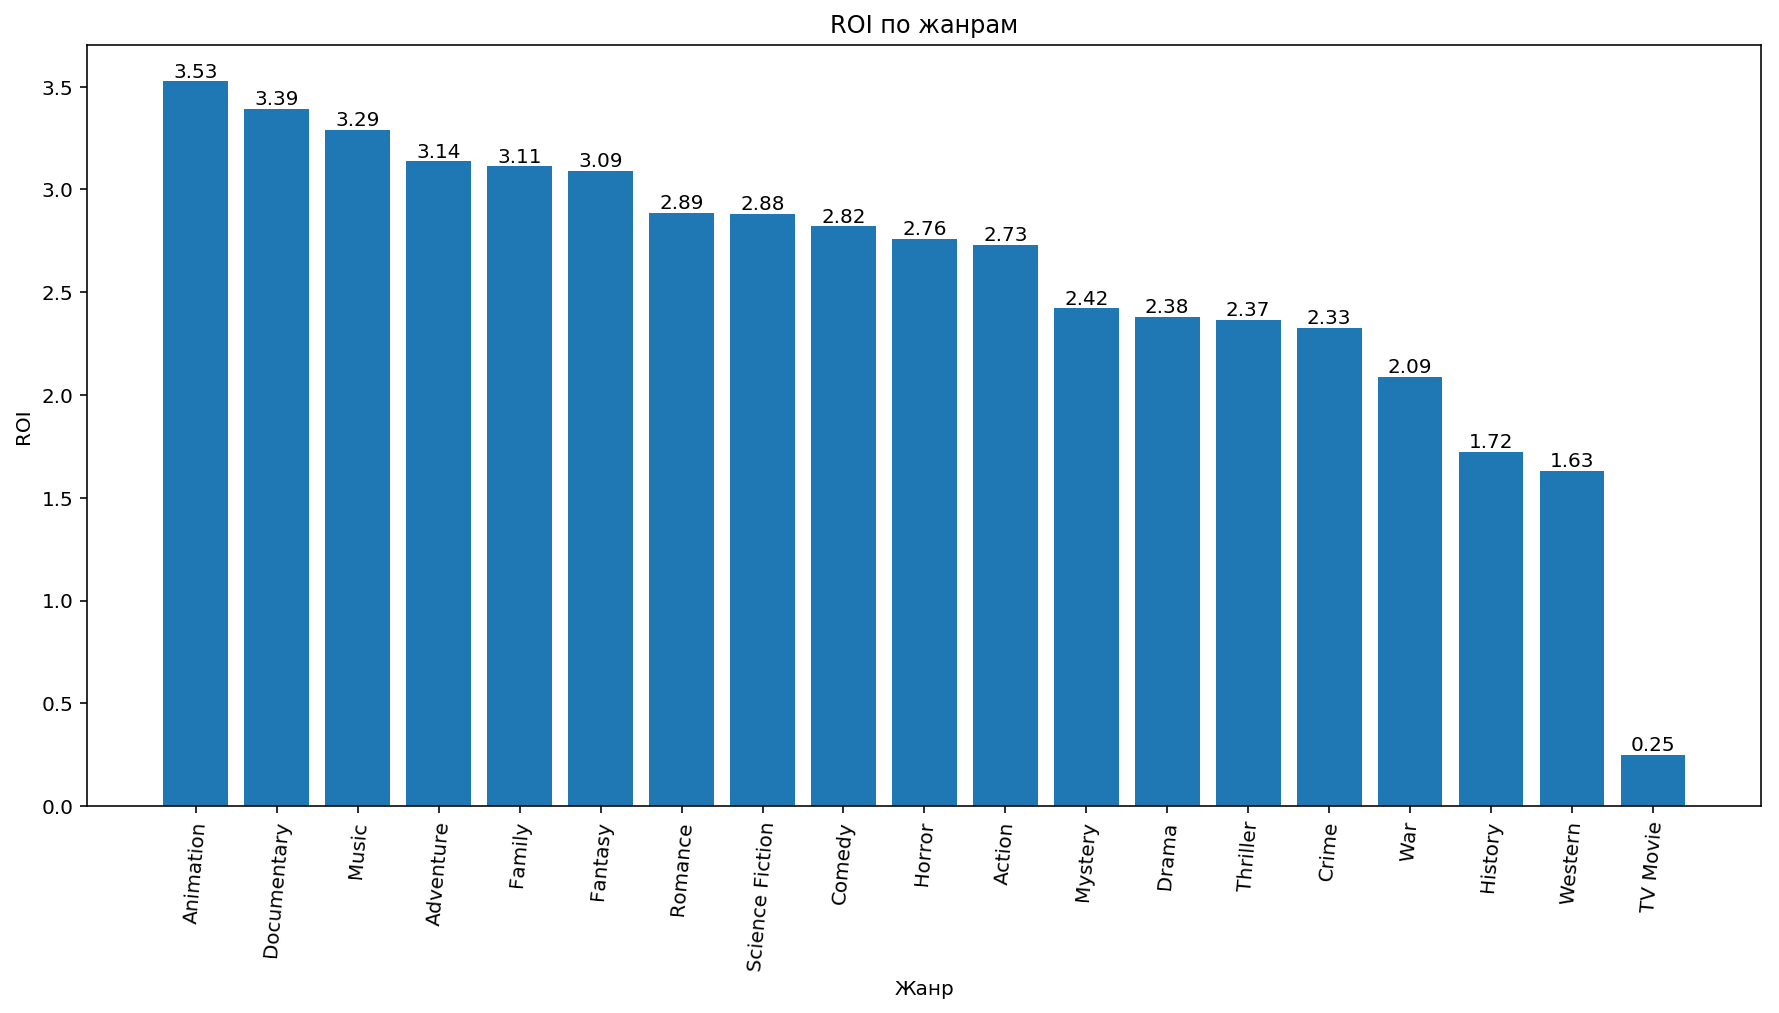

In [50]:
plt.figure(figsize=(15, 7))
plt.title('ROI по жанрам')
plt.xlabel('Жанр')
plt.ylabel('ROI')
for key, value in ROI:
    plt.text(x=key, y=value+.02, s='{:.2f}'.format(value), ha='center')
plt.bar(keys, values)
plt.xticks(rotation=85)
plt.show()